# Creepy Faces - mPyPl

Hello! You are about to take part in **#CreepyFaces** challenge, presented at [Pycon Berlin](http://pycon.de/), [PyCon Balkan](http://pyconbalkan.com/) and [PyCon Estonia](http://pycon.ee)!

> This version of the tutorial will use **[mPyPl](http://shwars.github.io/mPyPl)** Python library for monadic data manipulation. If you do not feel like using a new cool approach to processing data in Python - use another version of more "traditional" notebook. To use this tutorial comfortably, you may need to read through [mPyPl Tutorial](http://shwars.github.io/mPyPl/tutorial/) first.

The goal of the challenge would be to use **[Face API](https://docs.microsoft.com/azure/cognitive-services/face/overview/?wt.mc_id=crpyface-github-dmitryso)** to create artistic pictures in the genere of **Generative Science Art**. This tutorial would show you how to create pictures like this:

<img src="https://raw.githubusercontent.com/shwars/FaceArt/master/notebooks/img/PhoBoGuy.png" width="40%"/>

The main idea is that Face API allows us to extract coordinates of key points of the face - so called **Face Landmarks**. We will then use OpenCV machinery to apply some transformations to the image according to those key points. In the example above you can see several images blended together, aligned to the eyes.

This technique was originally proposed by [Dmitry Soshnikov](http://soshnikov.com) and called **Cognitive People Blending**. If you develop something substantially interesting, please share your results/feedback/ideas [with him](http://facebook.com/shwars).

### Some pre-requisites

We are going to do some image manipulations here, so we need OpenCV. It might not be included into our Python distribution, so to be on the safe side we will `pip`-install it. In addition, we would need `matplotlib` to show our results.

In [2]:
import sys
!{sys.executable} -m pip install opencv-python
import cv2
import matplotlib.pyplot as plt

You should consider upgrading via the 'pip install --upgrade pip' command.


We will also install **mPyPl** right away, even though we will start using it somewhere later in this tutorial.

In [6]:
!{sys.executable} -m pip install mPyPl
import mPyPl as mp
from mPyPl.utils.image import show_images 
print("Using mPyPl version {}".format(mp.__version__))

You should consider upgrading via the 'pip install --upgrade pip' command.
Using mPyPl version 0.0.3.7


### Extracting Facial Landmarks

To extract facial landmarks, we will use [Microsoft Face API](https://azure.microsoft.com/services/cognitive-services/face/?wt.mc_id=crpyface-github-dmitryso). It provides a simple REST API that can extract a lot of useful information from the face image, including those landmarks:

![Facial Landmarks](https://raw.githubusercontent.com/shwars/FaceArt/master/notebooks/img/landmarks.jpg)

It is quite easy to call Face API directly via REST, but it is even better to use existing SDK, which is available for Python as part of [Azure SDK library](https://docs.microsoft.com/ru-ru/azure/cognitive-services/face/quickstarts/python-sdk/?wt.mc_id=crpyface-github-dmitryso).

You can [visit Microsoft Docs](https://docs.microsoft.com/ru-ru/azure/cognitive-services/face/index/?wt.mc_id=crpyface-github-dmitryso) for more detailed information on Face API and using it from languages other than Python.

In [7]:
!{sys.executable} -m pip install azure-cognitiveservices-vision-face

You should consider upgrading via the 'pip install --upgrade pip' command.


To use Face API, we need to provide a key and endpoint URL (because it is available in different regions, URL can be different). There are many ways to obtain Face API Key:

* If you have an Azure Subscription, the best option is to [create Cognitive Services resource](https://docs.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account/?wt.mc_id=crpyface-github-dmitryso), and grab key/url from there
* You can always [create free trial subscription](https://azure.microsoft.com/free/?wt.mc_id=crpyface-github-dmitryso) (you would need a credit card for that)
* If you do not have an Azure Subscription, you can try Face API for free - request your trial key [here](https://azure.microsoft.com/try/cognitive-services/my-apis/?api=face-api&wt.mc_id=crpyface-github-dmitryso).

**Important:** If you use trial key, your Face API will have some limitations, in terms of number of images you can process, and frequency of API calls (not more than 20 calls per minute). In order to make things work, we would need to insert some pauses in between calls, when using API on a series of images.

After you get the key and endpoint, please insert them into the cell below. There would typically be two keys given on the portal, you can use any one of them.

In [1]:
key = '--INSERT YOUR KEY HERE--'
endpoint = 'https://westus2.api.cognitive.microsoft.com'
# Note that you may need a different URL, check the data on cognitive services page

Most of the calls of the Face API are done through the static module `cognitive_face`, which we will call `cf` for brevity.

In [9]:
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))

The main function for face detection is called `face.detect_with_url` or `face.detect_with_stream`. It can extract a lot of useful information from the face, depending on the parameters that you specify - in our case we would need facial landmarks:

In [16]:
res = cli.face.detect_with_url('https://2016.dotnext-piter.ru/assets/images/people/soshnikov.jpg',return_face_landmarks=True)
print(res[0])

{'additional_properties': {}, 'face_id': '423f6a20-3fb5-48fb-90d8-d69bee1ff395', 'recognition_model': None, 'face_rectangle': <azure.cognitiveservices.vision.face.models._models_py3.FaceRectangle object at 0x7f97276fb080>, 'face_landmarks': <azure.cognitiveservices.vision.face.models._models_py3.FaceLandmarks object at 0x7f97276fb048>, 'face_attributes': None}


**NB:** Sometimes when you pass binary data to cognitive services inside Azure Notebook, you can get SSL errors. If this happens, call the cell above with URL detection code, and then proceed with binary data detection.

### Getting some images

We need some images to play with. In this example, we will take 50 images of Bill Gates obtained from [Bing Image Search](https://docs.microsoft.com/azure/cognitive-services/bing-image-search/index/?wt.mc_id=crpyface-github-dmitryso). We will place them into `images` directory of this notebook. **NB:** this will take a while, and you need to wait for this cell to finish execution before proceeding.

In [11]:
import os
if not os.path.isdir('images'):
    !mkdir images
    !wget https://github.com/shwars/NeuroWorkshopData/raw/master/Data/Gates50.zip
    !unzip -q Gates50.zip -d images
    !rm Gates50.zip

--2019-09-30 08:34:21--  https://github.com/shwars/NeuroWorkshopData/raw/master/Data/Gates50.zip
Resolving webproxy (webproxy)... 10.36.53.1
Connecting to webproxy (webproxy)|10.36.53.1|:3128... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shwars/NeuroWorkshopData/master/Data/Gates50.zip [following]
--2019-09-30 08:34:22--  https://raw.githubusercontent.com/shwars/NeuroWorkshopData/master/Data/Gates50.zip
Connecting to webproxy (webproxy)|10.36.53.1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 19574121 (19M) [application/zip]
Saving to: ‘Gates50.zip’

Gates50.zip         100%[===================>]  18.67M   736KB/s    in 25s     

2019-09-30 08:34:48 (753 KB/s) - ‘Gates50.zip’ saved [19574121/19574121]



If you wish to experiment with your own pictures, just upload them into `images` directory using Azure Notebooks file upload feature. You can also use **ImageSearch** notebooks which comes with this repo to download images from **Bing Image Search** results.

Now to see this all in action, we will plot facial landmarks point over the face:

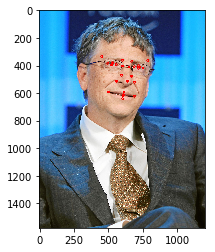

In [17]:
def imread(fn):
    im = cv2.imread(fn)
    return cv2.cvtColor(im,cv2.COLOR_BGR2RGB) if im is not None else None

img = imread('images/gates_0.jpg')
with open('images/gates_0.jpg','rb') as f:
    res = cli.face.detect_with_stream(f,return_face_landmarks=True)
for k,v in res[0].face_landmarks.as_dict().items():
    cv2.circle(img,(int(v['x']),int(v['y'])),7,(255,0,0),5)
plt.imshow(img)

If you get an SSL error above, call the following code before executing the cell:
```python
cli.face.detect_with_url('https://2016.dotnext-piter.ru/assets/images/people/soshnikov.jpg')
```

For our further experiments, let's load 10 first images, and run them through Face API to obtain facial landmarks. We will save the images into `images` array, and landmarks data into `imagepoints`. Here is where we will start using **mPyPl**:

In [24]:
def detect(fn):
    with open(fn,'rb') as f:
        return cli.face.detect_with_stream(f,return_face_landmarks=True)

data = (mp.get_files("images")
        | mp.as_field('filename')
        | mp.pshuffle
        | mp.take(10)
        | mp.apply('filename','image',imread)
        | mp.apply('filename','meta',detect)
        | mp.iter('filename',lambda x: print("Processing {}".format(x)))
        | mp.filter('meta',lambda x: x is not None and len(x)>0)
        | mp.apply('meta','faceland',lambda x: x[0].face_landmarks.as_dict())
        | mp.as_list)

print(data[0])

Processing images/gates_29.jpg
Processing images/gates_38.jpg
Processing images/gates_7.jpg
Processing images/gates_3.jpg
Processing images/gates_42.jpg
Processing images/gates_31.jpg
Processing images/gates_47.jpg
Processing images/gates_16.jpg
Processing images/gates_49.jpg
Processing images/gates_24.jpg
{'filename': 'images/gates_38.jpg', 'image': array([[[ 33,  32,  30],
        [ 33,  32,  30],
        [ 32,  31,  29],
        ...,
        [ 95,  90,  87],
        [ 95,  90,  87],
        [ 95,  90,  87]],

       [[ 33,  32,  30],
        [ 33,  32,  30],
        [ 32,  31,  29],
        ...,
        [ 95,  90,  87],
        [ 95,  90,  87],
        [ 95,  90,  87]],

       [[ 32,  31,  29],
        [ 32,  31,  29],
        [ 32,  31,  29],
        ...,
        [ 95,  90,  87],
        [ 95,  90,  87],
        [ 95,  90,  87]],

       ...,

       [[ 26,  26,  26],
        [ 26,  26,  26],
        [ 26,  26,  26],
        ...,
        [ 64,  69,  49],
        [101, 105,  78],
 

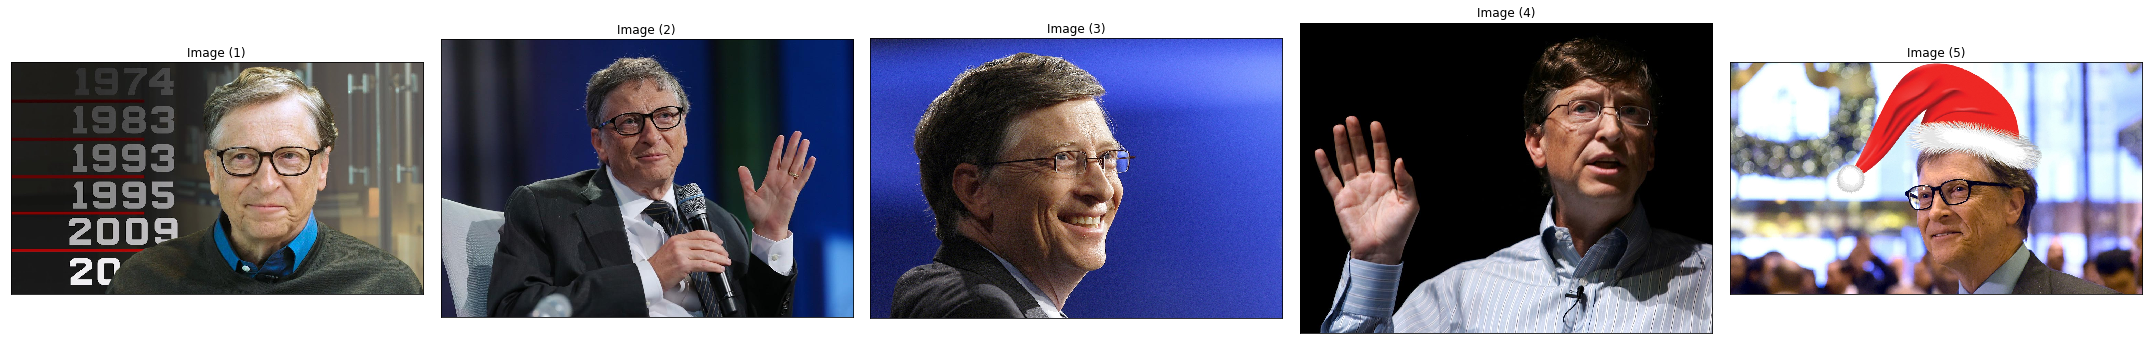

In [25]:
(data | mp.take(5) | mp.select_field('image') | mp.pexec(show_images))

## Affine Transformations

To get images all aligned, we need to position and rescale them according to the positions of eyes. To do that, we will use so-called [**affine transformation**](https://en.wikipedia.org/wiki/Affine_transformation). It includes many common image operations, such as scaling, rotation, skew, etc.

Such transformation can be defined in 2D-space using a matrix, and if we want to compute coordinates of a point after the transformation, we need to multiply them by this matrix. More precisely,
$$
\left(\begin{matrix}x'\cr y'\cr 1\end{matrix}\right) = M\times\left(\begin{matrix}x\cr y\cr 1\end{matrix}\right)
$$

In our case, we want to generate well-aligned portraits with eyes located at exactly the same position. Suppose the target image size is $300\times300$, then we can position eyes at points $(130,120)$ and $(170,120)$. 

It is known that affine transformation in 2D space can be uniquely defined by 3 points, i.e. we need to specify target coordinates for 3 given points in the image. In our case two such points will be left and right eye, and we need to chose the third point. A good choice would be to use some central point in the mouth, for example an average point between `mouth_left` and `mouth_right`.

In OpenCV, an affine transformation that maps given 3 points to another set of 3 points can be computed using `getAffineTransform` function. The resulting transformation can be applied to the whole image using `warpAffine` (and it also cuts out the remaining portions of the image, so that it fits the rectangle of the given size). 

Thus, the function to rotate our images to the fixes eyes-mouth position can be defined as follows:

In [27]:
import numpy as np

target_triangle = np.float32([[130.0,120.0],[170.0,120.0],[150.0,160.0]])
size = 300

def affine_transform(img,attrs):
    mc_x = (attrs['mouth_left']['x']+attrs['mouth_right']['x'])/2.0
    mc_y = (attrs['mouth_left']['y'] + attrs['mouth_right']['y']) / 2.0
    tr = cv2.getAffineTransform(np.float32([(attrs['pupil_left']['x'],attrs['pupil_left']['y']),
                                            (attrs['pupil_right']['x'],attrs['pupil_right']['y']),
                                            (mc_x,mc_y)]), target_triangle)                                
    return cv2.warpAffine(img,tr,(size,size))

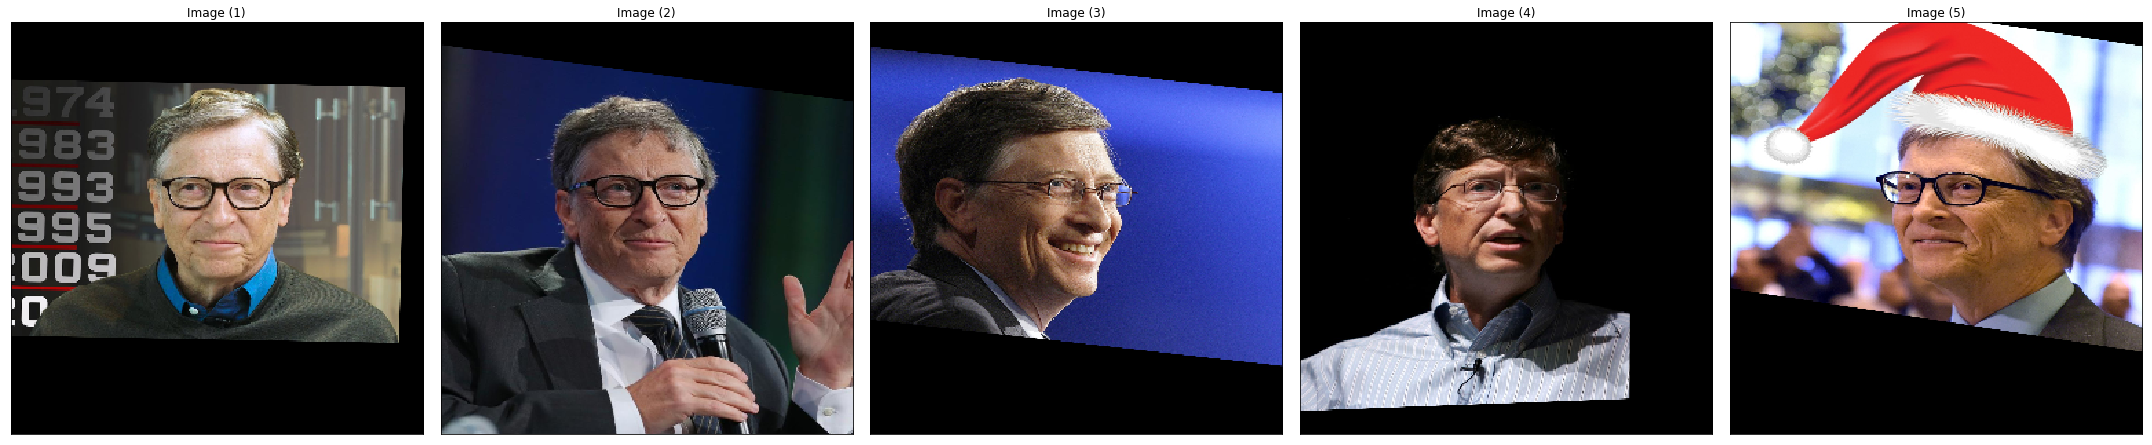

In [31]:
data_al = data | mp.apply(['image','faceland'],'aligned',lambda x: affine_transform(*x)) | mp.as_list

data_al | mp.take(5) | mp.select_field('aligned') | mp.pexec(show_images)

## Image Blending

Now we need to blend those images together to produce a nice result. Since images are represented in Python as `numpy` 3D-arrays, it is a simple operation of computing weighted average of those arrays. So, for two images $A$ and $B$, blended image can be computed as $C_{i,j,c} = \frac{1}{2}(A_{i,j,c}+B_{i,j,c})$ (here we denote by $c$ a color channel, so that $c\in\{1,2,3\}$).

In more general case, if $I^{(1)}, I^{(2)}, \dots, I^{(n)}$ are the images, and we want to blend them with different weights $\alpha_1, \alpha_2, \dots, \alpha_n$, such that $\alpha_1+\alpha_2+\dots+\alpha_n=1$, then the resulting merged image is computed as 
$$
M_{i,j,c} = \sum_{k=1}^n\alpha_k I^{(k)}_{i,j,c}
$$
or, in the matrix form,
$$
M = \sum_{k=1}^n\alpha_k I^{(k)} = \alpha_1 I^{(k)} + \dots + \alpha_n I^{(n)}
$$


In [40]:
def merge(images,wts=None):
    images = list(images)
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)
    return res.astype(np.int32)

In this function, if we do not specify weights vector - it is automatically assumed to be uniform.

Let's see how this function works for mixing two images:

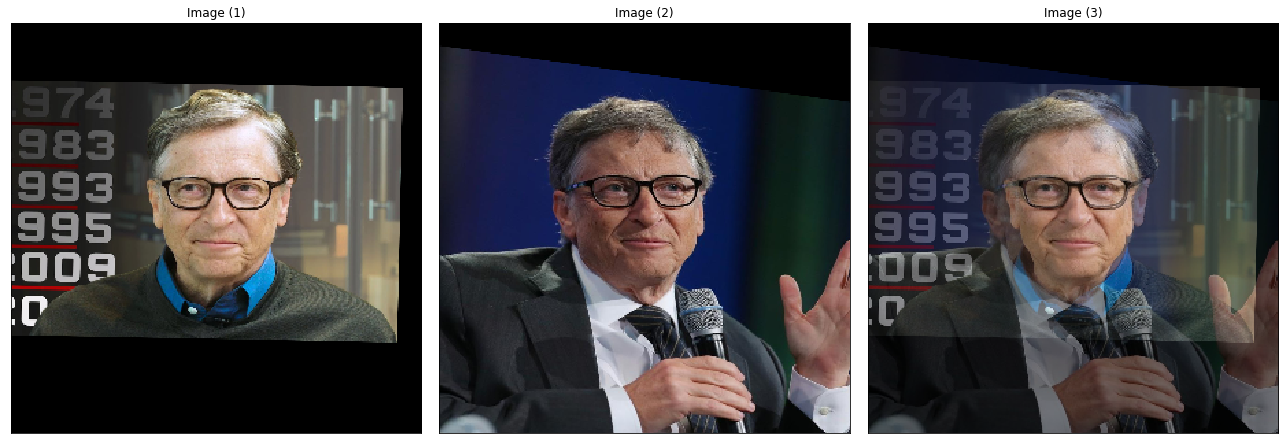

In [41]:
show_images([data_al[0]['aligned'],data_al[1]['aligned'],merge(data_al|mp.take(2)|mp.select_field('aligned')|mp.as_list)])

Now let's merge all aligned images altogether and see what happens:

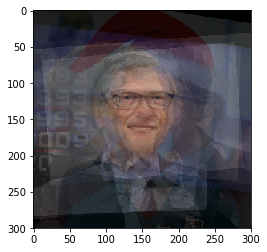

In [42]:
res = data_al | mp.select_field('aligned') | mp.pexec(merge)
plt.imshow(res)

If this image does not look good, we can vary weights of different images, producing different results:

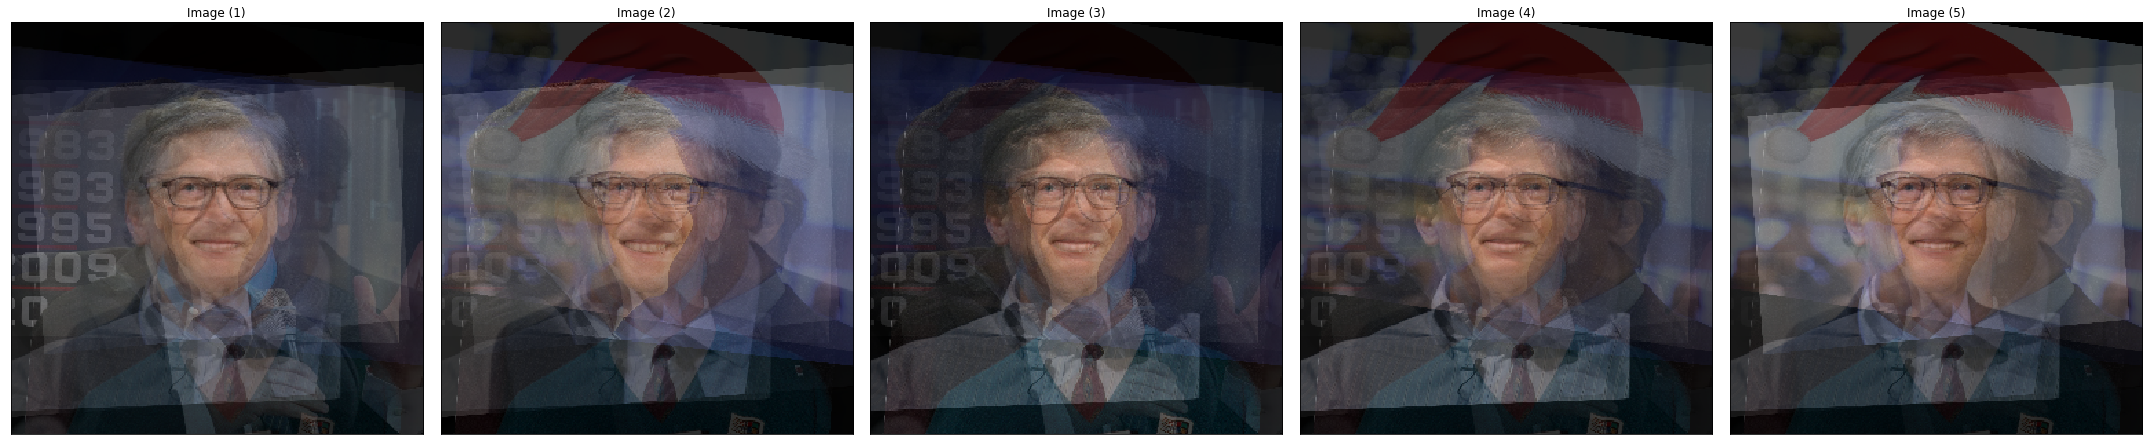

In [44]:
import functools

def rndmerge():
    return data_al | mp.select_field('aligned') | mp.pexec(functools.partial(merge,wts=np.random.random(len(data_al))))

range(5) | mp.select(lambda _ : rndmerge()) | mp.pexec(show_images)

## More Experimentation!

Feel free to experiment more with this technique, until you come up with some really beautiful result! Some ideas:

* Re-run the code, to use different random pictures from the collection
* Use some one else's pictures, getting them from the internet using `ImageGatherer` notebook
* Use your own pictures!
* Try aligning different facial points together
* Instead of alignment, you can experiment with different facial point placement on the picture

## Share the result!

We encourage you to share the results on social media (preferable Twitter), using hash tag **#creepyfaces**. Sample post is below:

> Look at one of the #creepyfaces I have produced at #PyCon using http://bit.ly/peopleblending technology!

Once you make a post, please submit the URL to us using REST Endpoint (which we have created, by the way, using [Azure Functions](https://docs.microsoft.com/azure/azure-functions/?wt.mc_id=crpyface-github-dmitryso). You need to specify your name (**as it is spelled on the conference badge**) in the cell below, and execute the code. Allow some time for execution.

In [30]:
name = 'John Doe, Jr.'
url = 'http://twitter.com/link-to-my-post'
event = 'pycon.de' # use pycon.de, pycon.ee, pycon.bal or any other event name

import requests

r = requests.get(url='https://contestman.azurewebsites.net/api/cfsubmit', params = { "name" : name, "url" : url, "event" : event })
r.content

b'Your submission is accepted, John Doe, Jr.'

### Cleanup

Finally, we delete the `images` directory to stay clean.

In [45]:
!rm -rf images